### Importing Necessary Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds
import os

### Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/GoogleDrive/')

Mounted at /content/GoogleDrive/


### Checking GPU Access

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Loading the Dataset

In [4]:
train_ds, val_ds, test_ds = tfds.load(
                                      'mnist',
                                       split = ['train[:50000]', 'train[50000:]', 'test'],
                                       as_supervised = True
)

# Source: https://www.tensorflow.org/datasets/api_docs/python/tfds/load, https://www.tensorflow.org/datasets/splits

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
tf.data.experimental.cardinality(train_ds).numpy(), tf.data.experimental.cardinality(val_ds).numpy(), tf.data.experimental.cardinality(test_ds).numpy()

(50000, 10000, 10000)

### Checking Class Distribution

In [6]:
def get_class_distribution(ds, num_classes):
  count = [0]*num_classes
  for item in ds:
    count[item[1].numpy()] += 1
  return count

In [7]:
get_class_distribution(train_ds, 10) # relatively balanced

[4964, 5613, 4959, 5114, 4855, 4509, 4930, 5208, 4878, 4970]

In [8]:
get_class_distribution(val_ds, 10) # relatively balanced as well

[959, 1129, 999, 1017, 987, 912, 988, 1057, 973, 979]

### Data Preprocessing

In [9]:
def normalize(image, label):
  return tf.cast(image, tf.float32) / 255., label

def preprocess(ds, training = True):
  ds = ds.map(normalize, num_parallel_calls = tf.data.AUTOTUNE)
  if training:
    ds = ds.cache()
    ds = ds.shuffle(50000)
    ds = ds.batch(64)
    ds = ds.prefetch(tf.data.AUTOTUNE)
  else:
    ds = ds.batch(64)
    ds = ds.cache()
    ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

# Source: https://www.tensorflow.org/datasets/keras_example

In [10]:
train_ds = preprocess(train_ds)
val_ds = preprocess(val_ds, training = False)
test_ds = preprocess(test_ds, training = False)

### Creating the Model

In [11]:
! pip install git+https://github.com/fversaci/WaveTF.git 

  Cloning https://github.com/fversaci/WaveTF.git to /tmp/pip-req-build-xela61oy
  Running command git clone -q https://github.com/fversaci/WaveTF.git /tmp/pip-req-build-xela61oy
  Created wheel for WaveTF: filename=WaveTF-0.1-py3-none-any.whl size=25282 sha256=7faff05559e9130fb3070f063dead82082f6ee9e4d873739c6180defc9be340e
  Stored in directory: /tmp/pip-ephem-wheel-cache-pvgeozzv/wheels/8e/ec/3d/1b322bbe7f99f023e33f5ae0fa6716e29abadde70a3ac6d299
Successfully built WaveTF


In [12]:
from wavetf import WaveTFFactory

In [13]:
class WaveletBlock(layers.Layer):
  def __init__(self, input_channels, wavelet, interpolation, **kwargs):
    super().__init__(**kwargs)
    self.input_channels = input_channels
    self.wavelet = wavelet
    self.interpolation = interpolation
    self.wavelet_transform = WaveTFFactory.build(wavelet)
    self.cA = [layers.UpSampling2D(size = (2,2), interpolation = interpolation),
               layers.DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same'),
               layers.BatchNormalization(),
               layers.Activation('relu')
              ]
    self.cH = [layers.UpSampling2D(size = (2,2), interpolation = interpolation),
               layers.DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same'),
               layers.BatchNormalization(),
               layers.Activation('relu')
              ]
    self.cV = [layers.UpSampling2D(size = (2,2), interpolation = interpolation),
               layers.DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same'),
               layers.BatchNormalization(),
               layers.Activation('relu')
              ]
    self.cD = [layers.UpSampling2D(size = (2,2), interpolation = interpolation),
               layers.DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same'),
               layers.BatchNormalization(),
               layers.Activation('relu')
              ]
    self.concat = layers.Concatenate(axis = -1)
    self.linear = [layers.Conv2D(filters = input_channels, kernel_size = (1,1), strides = (1,1), padding = 'same'),
                   layers.BatchNormalization()
                  ]
    self.batchnorm = [layers.BatchNormalization(),
                      layers.Activation('relu')]

  def call(self, inputs):
    z = self.wavelet_transform(inputs)

    cA = z[:,:,:,:self.input_channels]
    cV = z[:,:,:,self.input_channels:2*self.input_channels]
    cH = z[:,:,:,2*self.input_channels:3*self.input_channels]
    cD = z[:,:,:,3*self.input_channels:]

    for layer in self.cA:
      cA = layer(cA)
    for layer in self.cV:
      cV = layer(cV) 
    for layer in self.cH:
      cH = layer(cH) 
    for layer in self.cD:
      cD = layer(cD) 
    
    out = self.concat([cA,cV,cH,cD])

    for layer in self.linear:
      out = layer(out)
      
    final = out + inputs

    for layer in self.batchnorm:
      final = layer(final)
    
    return final

In [14]:
def build_mnist_model(wavelet, interpolation):
  model = Sequential([layers.Input(shape = (28, 28, 1), name = 'input'),
                      layers.RandomRotation(factor = 10/360, name = 'random_rotation'),
                      layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_1'),
                      layers.BatchNormalization(name = 'conv2d_1_bn'),
                      layers.Activation('relu', name = 'conv2d_1_relu'),
                      WaveletBlock(input_channels = 32, wavelet = wavelet, interpolation = interpolation, name = 'wavelet_block_1'),
                      layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), padding = 'same', name = 'conv2d_2'),
                      layers.BatchNormalization(name = 'conv2d_2_bn'),
                      layers.Activation('relu', name = 'conv2d_2_relu'),
                      WaveletBlock(input_channels = 64, wavelet = wavelet, interpolation = interpolation, name = 'wavelet_block_2'),
                      layers.Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_3'),
                      layers.BatchNormalization(name = 'conv2d_3_bn'),
                      layers.Activation('relu', name = 'conv2d_3_relu'),
                      layers.GlobalAveragePooling2D(name = 'avgpooling'),
                      layers.Dropout(0.4, name = 'dropout'),
                      layers.Dense(units = 10, activation = 'softmax', name = 'predictions')],
                     name = f'{wavelet}_{interpolation}_model')
  return model

In [15]:
def train_model(model, wavelet, interpolation, initial_epoch = 0, epochs = 100):
  optimizer = tf.keras.optimizers.Adam(0.001)
  model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
  dir_model = f'GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/mnist/{wavelet}_{interpolation}_mnist.h5'
  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(dir_model, save_best_only = True, save_weights_only = True)
  with tf.device('/device:GPU:0'):
    history = model.fit(
                        x = train_ds,
                        initial_epoch = initial_epoch,
                        epochs = epochs, 
                        callbacks = [checkpoint_cb],
                        validation_data = val_ds
                        )
  return history

### Haar-Nearest

In [16]:
haar_nearest = build_mnist_model('haar', 'nearest')

In [17]:
haar_nearest.summary()

Model: "haar_nearest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 28, 28, 1)        0         
 tion)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_1_bn (BatchNormaliza  (None, 28, 28, 32)       128       
 tion)                                                           
                                                                 
 conv2d_1_relu (Activation)  (None, 28, 28, 32)        0         
                                                                 
 wavelet_block_1 (WaveletBlo  (None, 28, 28, 32)       6176      
 ck)                                                             
                                                

In [18]:
haar_nearest_history = train_model(haar_nearest, 'haar', 'nearest')

Epoch 1/100
782/782 [==============================] - 48s 39ms/step - loss: 0.3673 - accuracy: 0.9008 - val_loss: 0.1151 - val_accuracy: 0.9686
Epoch 2/100
782/782 [==============================] - 28s 36ms/step - loss: 0.1005 - accuracy: 0.9712 - val_loss: 0.0913 - val_accuracy: 0.9715
Epoch 3/100
782/782 [==============================] - 29s 37ms/step - loss: 0.0746 - accuracy: 0.9785 - val_loss: 0.0569 - val_accuracy: 0.9835
Epoch 4/100
782/782 [==============================] - 29s 36ms/step - loss: 0.0619 - accuracy: 0.9809 - val_loss: 0.0550 - val_accuracy: 0.9829
Epoch 5/100
782/782 [==============================] - 28s 36ms/step - loss: 0.0523 - accuracy: 0.9845 - val_loss: 0.0649 - val_accuracy: 0.9809
Epoch 6/100
782/782 [==============================] - 28s 36ms/step - loss: 0.0494 - accuracy: 0.9849 - val_loss: 0.0688 - val_accuracy: 0.9798
Epoch 7/100
782/782 [==============================] - 28s 36ms/step - loss: 0.0422 - accuracy: 0.9875 - val_loss: 0.1075 - val_ac

In [19]:
haar_nearest.evaluate(test_ds)

157/157 [==============================] - 2s 11ms/step - loss: 0.0287 - accuracy: 0.9928


[0.028690796345472336, 0.9927999973297119]

In [20]:
haar_nearest_saved = build_mnist_model('haar', 'nearest')
haar_nearest_saved.load_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/mnist/haar_nearest_mnist.h5')
haar_nearest_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
haar_nearest_saved.evaluate(test_ds)

157/157 [==============================] - 2s 10ms/step - loss: 0.0292 - accuracy: 0.9924


[0.029185431078076363, 0.9923999905586243]

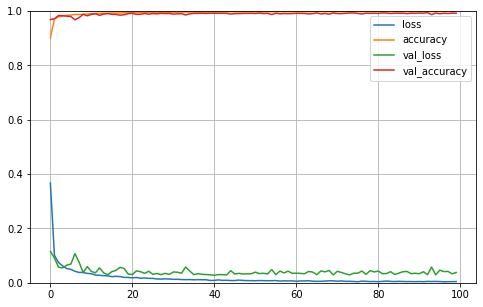

In [21]:
pd.DataFrame(haar_nearest_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [43]:
haar_nearest.save_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/mnist/haar_nearest_mnist_last_epoch.h5')

### Haar-Bilinear

In [22]:
haar_bilinear = build_mnist_model('haar', 'bilinear')

In [23]:
haar_bilinear_history = train_model(haar_bilinear, 'haar', 'bilinear')

Epoch 1/100
782/782 [==============================] - 36s 41ms/step - loss: 0.3194 - accuracy: 0.9134 - val_loss: 0.1126 - val_accuracy: 0.9698
Epoch 2/100
782/782 [==============================] - 29s 37ms/step - loss: 0.0875 - accuracy: 0.9755 - val_loss: 0.1283 - val_accuracy: 0.9594
Epoch 3/100
782/782 [==============================] - 29s 37ms/step - loss: 0.0672 - accuracy: 0.9801 - val_loss: 0.1647 - val_accuracy: 0.9468
Epoch 4/100
782/782 [==============================] - 29s 38ms/step - loss: 0.0565 - accuracy: 0.9829 - val_loss: 0.0439 - val_accuracy: 0.9861
Epoch 5/100
782/782 [==============================] - 29s 38ms/step - loss: 0.0505 - accuracy: 0.9841 - val_loss: 0.0416 - val_accuracy: 0.9882
Epoch 6/100
782/782 [==============================] - 29s 37ms/step - loss: 0.0462 - accuracy: 0.9865 - val_loss: 0.3064 - val_accuracy: 0.9207
Epoch 7/100
782/782 [==============================] - 30s 38ms/step - loss: 0.0435 - accuracy: 0.9864 - val_loss: 0.0411 - val_ac

In [24]:
haar_bilinear.evaluate(test_ds)

157/157 [==============================] - 2s 10ms/step - loss: 0.0266 - accuracy: 0.9934


[0.026551319286227226, 0.993399977684021]

In [25]:
haar_bilinear_saved = build_mnist_model('haar', 'bilinear')
haar_bilinear_saved.load_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/mnist/haar_bilinear_mnist.h5')
haar_bilinear_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
haar_bilinear_saved.evaluate(test_ds)

157/157 [==============================] - 2s 11ms/step - loss: 0.0244 - accuracy: 0.9927


[0.02443821169435978, 0.9926999807357788]

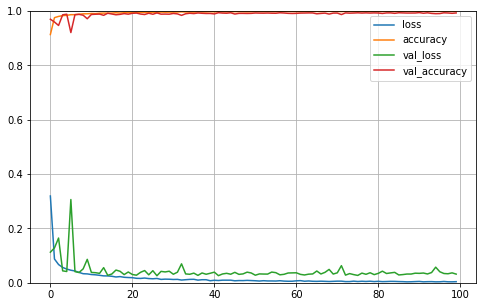

In [26]:
pd.DataFrame(haar_bilinear_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [45]:
haar_bilinear.save_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/mnist/haar_bilinear_mnist_last_epoch.h5')

### DB2-Nearest

In [27]:
db2_nearest = build_mnist_model('db2', 'nearest')

In [28]:
db2_nearest_history = train_model(db2_nearest, 'db2', 'nearest')

Epoch 1/100
782/782 [==============================] - 37s 43ms/step - loss: 0.3592 - accuracy: 0.9047 - val_loss: 0.1260 - val_accuracy: 0.9640
Epoch 2/100
782/782 [==============================] - 34s 44ms/step - loss: 0.0949 - accuracy: 0.9737 - val_loss: 0.1257 - val_accuracy: 0.9603
Epoch 3/100
782/782 [==============================] - 36s 45ms/step - loss: 0.0695 - accuracy: 0.9806 - val_loss: 0.0572 - val_accuracy: 0.9825
Epoch 4/100
782/782 [==============================] - 33s 43ms/step - loss: 0.0601 - accuracy: 0.9819 - val_loss: 0.0847 - val_accuracy: 0.9733
Epoch 5/100
782/782 [==============================] - 33s 43ms/step - loss: 0.0516 - accuracy: 0.9845 - val_loss: 0.0809 - val_accuracy: 0.9758
Epoch 6/100
782/782 [==============================] - 34s 43ms/step - loss: 0.0471 - accuracy: 0.9857 - val_loss: 0.0417 - val_accuracy: 0.9862
Epoch 7/100
782/782 [==============================] - 33s 43ms/step - loss: 0.0438 - accuracy: 0.9863 - val_loss: 0.0554 - val_ac

In [29]:
db2_nearest.evaluate(test_ds)

157/157 [==============================] - 2s 11ms/step - loss: 0.0369 - accuracy: 0.9919


[0.036858223378658295, 0.9919000267982483]

In [30]:
db2_nearest_saved = build_mnist_model('db2', 'nearest')
db2_nearest_saved.load_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/mnist/db2_nearest_mnist.h5')
db2_nearest_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
db2_nearest_saved.evaluate(test_ds)

157/157 [==============================] - 3s 11ms/step - loss: 0.0255 - accuracy: 0.9932


[0.02545665204524994, 0.9932000041007996]

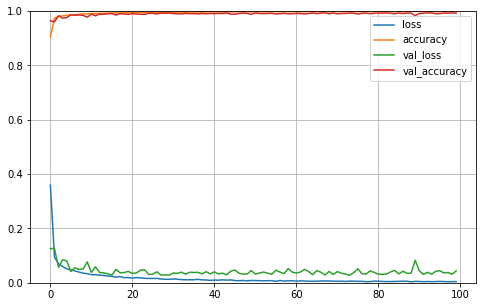

In [31]:
pd.DataFrame(db2_nearest_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [46]:
db2_nearest.save_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/mnist/db2_nearest_mnist_last_epoch.h5')

### DB2-Bilinear

In [32]:
db2_bilinear = build_mnist_model('db2', 'bilinear')

In [33]:
db2_bilinear_history = train_model(db2_bilinear, 'db2', 'bilinear')

Epoch 1/100
782/782 [==============================] - 37s 44ms/step - loss: 0.3402 - accuracy: 0.9074 - val_loss: 0.1075 - val_accuracy: 0.9721
Epoch 2/100
782/782 [==============================] - 35s 44ms/step - loss: 0.0920 - accuracy: 0.9741 - val_loss: 0.0671 - val_accuracy: 0.9775
Epoch 3/100
782/782 [==============================] - 34s 43ms/step - loss: 0.0705 - accuracy: 0.9789 - val_loss: 0.1864 - val_accuracy: 0.9445
Epoch 4/100
782/782 [==============================] - 34s 44ms/step - loss: 0.0578 - accuracy: 0.9831 - val_loss: 0.0643 - val_accuracy: 0.9778
Epoch 5/100
782/782 [==============================] - 33s 43ms/step - loss: 0.0501 - accuracy: 0.9853 - val_loss: 0.2425 - val_accuracy: 0.9289
Epoch 6/100
782/782 [==============================] - 34s 44ms/step - loss: 0.0450 - accuracy: 0.9867 - val_loss: 0.0370 - val_accuracy: 0.9888
Epoch 7/100
782/782 [==============================] - 34s 43ms/step - loss: 0.0410 - accuracy: 0.9876 - val_loss: 0.0387 - val_ac

In [34]:
db2_bilinear.evaluate(test_ds)

157/157 [==============================] - 2s 11ms/step - loss: 0.0306 - accuracy: 0.9917


[0.030617404729127884, 0.9916999936103821]

In [35]:
db2_bilinear_saved = build_mnist_model('db2', 'bilinear')
db2_bilinear_saved.load_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/mnist/db2_bilinear_mnist.h5')
db2_bilinear_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
db2_bilinear_saved.evaluate(test_ds)

157/157 [==============================] - 3s 12ms/step - loss: 0.0210 - accuracy: 0.9933


[0.021007204428315163, 0.9933000206947327]

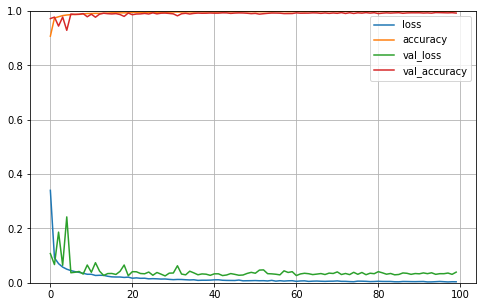

In [36]:
pd.DataFrame(db2_bilinear_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [47]:
db2_bilinear.save_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/mnist/db2_bilinear_mnist_last_epoch.h5')

### Fully Conv

In [37]:
fully_conv = Sequential([layers.Input(shape = (28, 28, 1), name = 'input'),
                      layers.RandomRotation(factor = 10/360, name = 'random_rotation'),
                      layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_1'),
                      layers.BatchNormalization(name = 'conv2d_1_bn'),
                      layers.Activation('relu', name = 'conv2d_1_relu'),
                      layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_2'),
                      layers.BatchNormalization(name = 'conv2d_2_bn'),
                      layers.Activation('relu', name = 'conv2d_2_relu'),
                      layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), padding = 'same', name = 'conv2d_3'),
                      layers.BatchNormalization(name = 'conv2d_3_bn'),
                      layers.Activation('relu', name = 'conv2d_3_relu'),
                      layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_4'),
                      layers.BatchNormalization(name = 'conv2d_4_bn'),
                      layers.Activation('relu', name = 'conv2d_4_relu'),
                      layers.Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_5'),
                      layers.BatchNormalization(name = 'conv2d_5_bn'),
                      layers.Activation('relu', name = 'conv2d_5_relu'),
                      layers.GlobalAveragePooling2D(name = 'avgpooling'),
                      layers.Dropout(0.4, name = 'dropout'),
                      layers.Dense(units = 10, activation = 'softmax', name = 'predictions')],
                     name = f'fully_conv_model')

In [38]:
fully_conv.summary()

Model: "fully_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 28, 28, 1)        0         
 tion)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_1_bn (BatchNormaliza  (None, 28, 28, 32)       128       
 tion)                                                           
                                                                 
 conv2d_1_relu (Activation)  (None, 28, 28, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 conv2d_2_bn (BatchNormaliza  (None, 28, 28, 32)  

In [39]:
optimizer = tf.keras.optimizers.Adam(0.001)
fully_conv.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
dir_model = 'GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/mnist/fully_conv_mnist.h5'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(dir_model, save_best_only = True)
with tf.device('/device:GPU:0'):
  fully_conv_history = fully_conv.fit(
                        x = train_ds,
                        epochs = 100, 
                        callbacks = [checkpoint_cb],
                        validation_data = val_ds
                        )

Epoch 1/100
782/782 [==============================] - 9s 10ms/step - loss: 0.3521 - accuracy: 0.9115 - val_loss: 0.1511 - val_accuracy: 0.9552
Epoch 2/100
782/782 [==============================] - 8s 10ms/step - loss: 0.0969 - accuracy: 0.9738 - val_loss: 0.0739 - val_accuracy: 0.9793
Epoch 3/100
782/782 [==============================] - 8s 10ms/step - loss: 0.0734 - accuracy: 0.9788 - val_loss: 0.0845 - val_accuracy: 0.9752
Epoch 4/100
782/782 [==============================] - 8s 10ms/step - loss: 0.0608 - accuracy: 0.9822 - val_loss: 0.1625 - val_accuracy: 0.9509
Epoch 5/100
782/782 [==============================] - 9s 11ms/step - loss: 0.0537 - accuracy: 0.9839 - val_loss: 0.0540 - val_accuracy: 0.9820
Epoch 6/100
782/782 [==============================] - 8s 10ms/step - loss: 0.0472 - accuracy: 0.9862 - val_loss: 0.2221 - val_accuracy: 0.9363
Epoch 7/100
782/782 [==============================] - 9s 11ms/step - loss: 0.0441 - accuracy: 0.9866 - val_loss: 0.0440 - val_accuracy:

In [40]:
fully_conv.evaluate(test_ds)

157/157 [==============================] - 1s 4ms/step - loss: 0.0279 - accuracy: 0.9933


[0.027890469878911972, 0.9933000206947327]

In [41]:
fully_conv_saved = keras.models.load_model('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/mnist/fully_conv_mnist.h5')
fully_conv_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
fully_conv_saved.evaluate(test_ds)

157/157 [==============================] - 1s 4ms/step - loss: 0.0152 - accuracy: 0.9958


[0.015201632864773273, 0.9958000183105469]

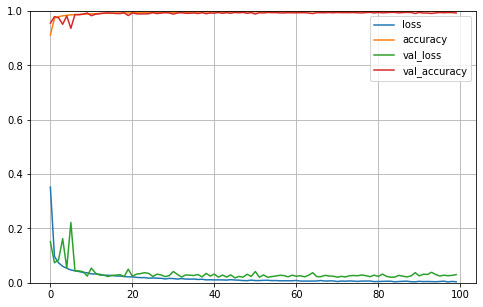

In [42]:
pd.DataFrame(fully_conv_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [48]:
fully_conv.save_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/mnist/fully_conv_mnist_last_epoch.h5')